Testing Zone

In [8]:
# import tensorflow as tf
# from tensorflow.keras import layers
# import matplotlib.pyplot as plt

# # Define the data augmentation layers
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(factor=(-0.25, 0.25)),  # Rotate images by up to ±25% of a full circle (±90 degrees)
#     layers.RandomContrast(factor=0.2),            # Adjust contrast by a factor of up to ±20%
#     layers.RandomBrightness(factor=0.2)           # Adjust brightness by a factor of up to ±20%
# ])

# # Load dataset (replace with your dataset loading code)
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "data",  # Replace with the path to your dataset
#     image_size=(256, 256),  # Resize images to 224x224
#     batch_size=32
# )

# # Get class names
# class_names = dataset.class_names

# # Take one batch of images
# for image_batch, label_batch in dataset.take(1):
#     # Pick the first image and its label
#     original_image = image_batch[0]
#     label = label_batch[0]

#     # Apply data augmentation
#     augmented_image = data_augmentation(tf.expand_dims(original_image, 0))

#     # Display the original and augmented images side by side
#     plt.figure(figsize=(10, 5))

#     # Original image
#     plt.subplot(1, 2, 1)
#     plt.imshow(original_image.numpy().astype("uint8"))
#     plt.title(f"Original - {class_names[label]}")
#     plt.axis("off")

#     # Augmented image
#     plt.subplot(1, 2, 2)
#     plt.imshow(augmented_image[0].numpy().astype("uint8"))
#     plt.title(f"Augmented - {class_names[label]}")
#     plt.axis("off")

#     plt.show()

#     # Break after the first batch to avoid processing further batches
#     break



In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt



In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=50
TRAINING_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

Preprocessing

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


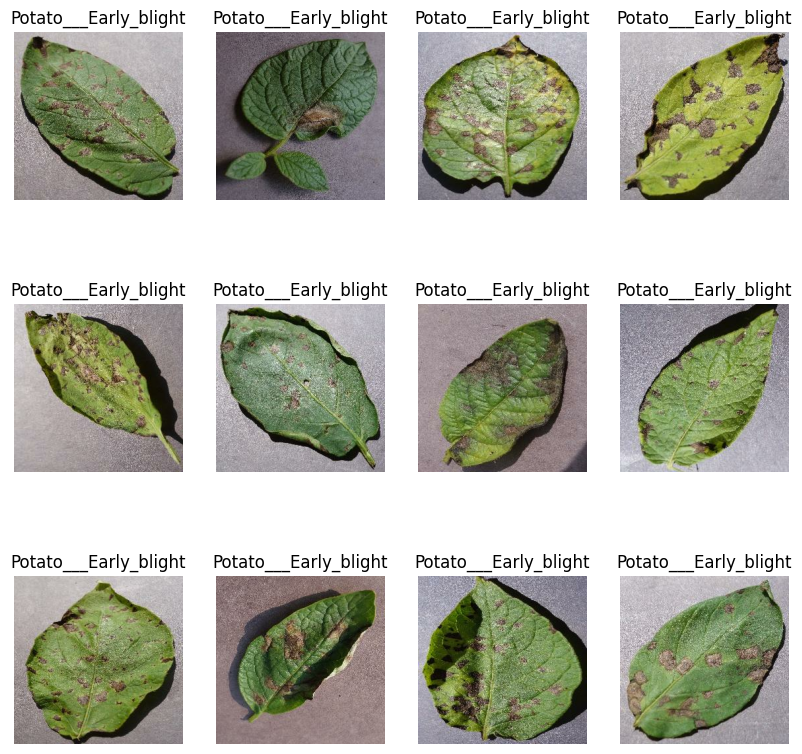

In [4]:
class_names=dataset.class_names
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

80% data for training 10% for validation after each epoch, 10% for testing

In [5]:
def get_dataset_partition_tf(ds, train_ratio=0.8,valid_ratio=0.1,test_ratio=0.1,shuffle_size=10000,shuffle=True):
    ds_size=len(dataset)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=11)
    
    train_Dsize=np.round(ds_size*train_ratio)
    valid_Dsize=np.round(ds_size*valid_ratio)
    test_Dsize= ds_size-(train_Dsize+valid_Dsize)
    
    train_ds=dataset.take(train_Dsize)
    test_ds=dataset.skip(train_Dsize)
    valid_ds=test_ds.take(valid_Dsize)
    test_ds=test_ds.skip(valid_Dsize)
    
    return train_ds,valid_ds,test_ds

In [6]:
train_ds,valid_ds,test_ds=get_dataset_partition_tf(dataset)
print(len(train_ds),len(valid_ds),len(test_ds))

54 7 7


OPTIMIZATION

In [7]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)])

Data Augmentation Layer

In [63]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=(-0.25, 0.25)),  # Rotate images by up to ±25% of a full circle (±90 degrees)
    # layers.RandomContrast(factor=0.01),            # Adjust contrast by a factor of up to ±20%
    # layers.RandomBrightness(factor=0.01)           # Adjust brightness by a factor of up to ±20%
])

In [91]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescaling, 
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [92]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[ 'accuracy']
)

In [93]:
history = model.fit(
    train_ds, 
    epochs=EPOCH+10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds
)

Epoch 1/60


54/54 [==============================] - 11s 155ms/step - loss: 0.9185 - accuracy: 0.5284 - val_loss: 0.8608 - val_accuracy: 0.5089
Epoch 2/60
54/54 [==============================] - 8s 150ms/step - loss: 0.7190 - accuracy: 0.6858 - val_loss: 0.4868 - val_accuracy: 0.8259
Epoch 3/60
54/54 [==============================] - 8s 148ms/step - loss: 0.4362 - accuracy: 0.8229 - val_loss: 0.3022 - val_accuracy: 0.8973
Epoch 4/60
54/54 [==============================] - 8s 146ms/step - loss: 0.3213 - accuracy: 0.8750 - val_loss: 0.4688 - val_accuracy: 0.8527
Epoch 5/60
54/54 [==============================] - 8s 147ms/step - loss: 0.2901 - accuracy: 0.8872 - val_loss: 0.2716 - val_accuracy: 0.9107
Epoch 6/60
54/54 [==============================] - 8s 145ms/step - loss: 0.2626 - accuracy: 0.8999 - val_loss: 0.2448 - val_accuracy: 0.8973
Epoch 7/60
54/54 [==============================] - 8s 147ms/step - loss: 0.2675 - accuracy: 0.8918 - val_loss: 0.2027 - val_accuracy: 0.9330
Epoch 8/60
54/54

In [94]:
scores = model.evaluate(test_ds)
print(scores)

7/7 [==============================] - 0s 26ms/step - loss: 0.0083 - accuracy: 0.9950
[0.008312463760375977, 0.9950000047683716]


In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


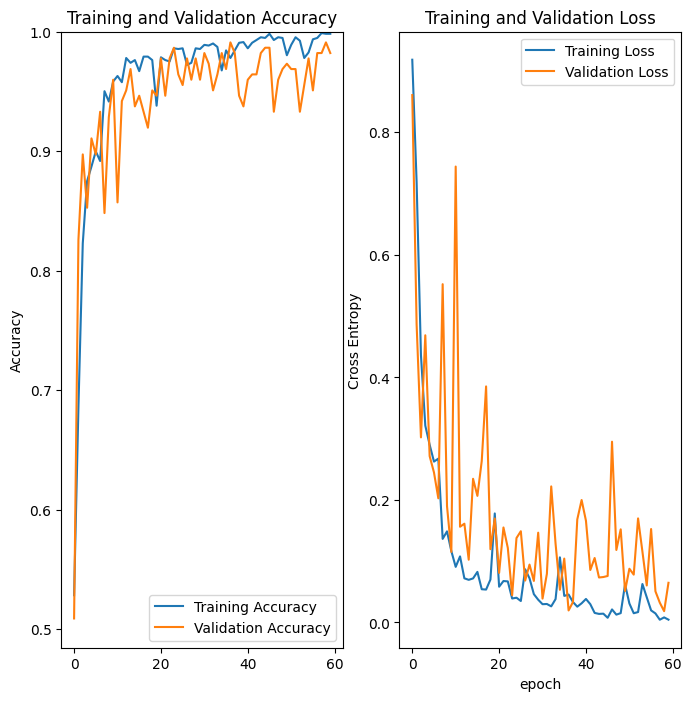

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



First image in the batch:
Label: Potato___Early_blight
1/1 [==============================] - 0s 120ms/step
Model prediction: Potato___Early_blight
Confidence: 100.00%


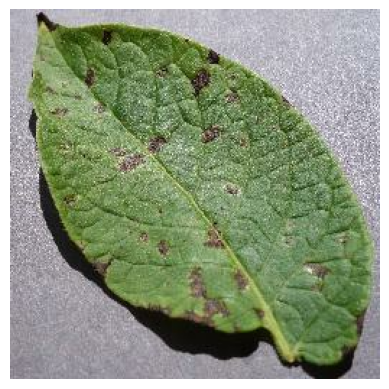

In [97]:
for image_batch, label_batch in test_ds.take(1):
    plt.axis("off")
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    print("First image in the batch:")
    plt.imshow(first_image)
    print(f"Label: {class_names[first_label]}")
    batch_prediction = model.predict(image_batch)
    print(f"Model prediction: {class_names[np.argmax(batch_prediction[0])]}")
    print(f"Confidence: {np.max(batch_prediction[0]) * 100:.2f}%")
    plt.show()
    
    

In [98]:
def predict(model, image):

    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round((np.max(predictions[0]) * 100), 4)
    
    return predicted_class, confidence
    

    
        

1/1 [==============================] - 0s 20ms/step


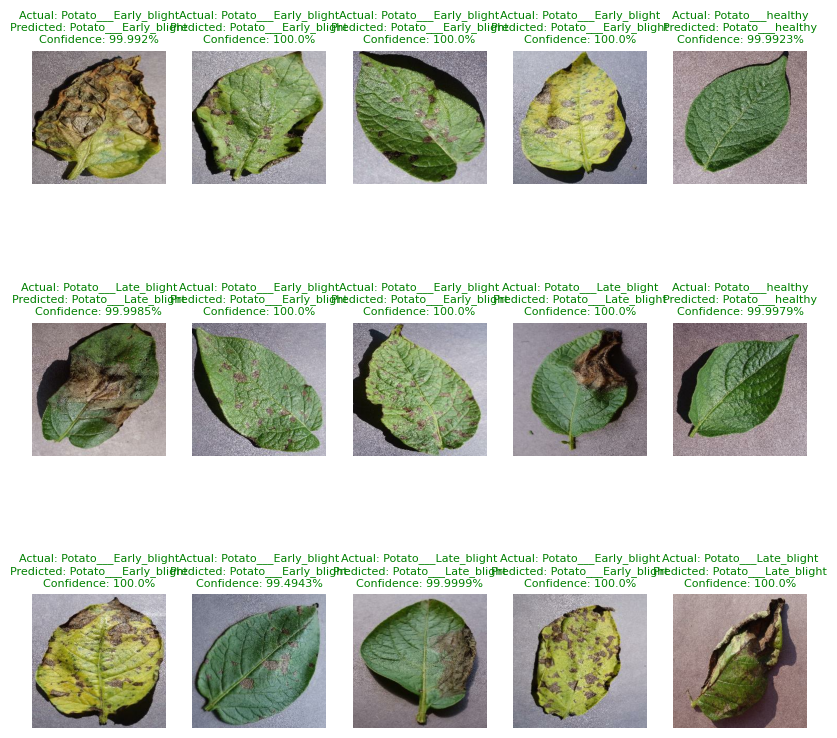

In [100]:
for image_batch, label_batch in test_ds.take(1):
    plt.figure(figsize=(10, 10))
    
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # plt.title(f"Actual: {class_names[label_batch[i]]}")
        predicted_class, confidence = predict(model, image_batch)
        plt.title(f"Actual: {class_names[label_batch[i]]}\nPredicted: {predicted_class}\nConfidence: {confidence}%",color=("green" if class_names[label_batch[i]] == predicted_class else "red"),fontsize=8)
        plt.axis("off")
    plt.show()



In [1]:
import os
model_name="potato_blight_model"
model_version=max([int(i) for i in os.listdir(f"../models/{model_name}")])+1

print(model_name,model_version)
# model.save(f"../models/{model_name}/{model_version}")


# model.save(f"../models/{model_name}/{model_version}")


potato_blight_model 3


NameError: name 'model' is not defined

In [3]:
import os
from tensorflow.keras.models import load_model, save_model

model_name = "potato_blight_model"
model_dir = f"../models/{model_name}"

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Determine the latest version number
existing_versions = [int(i) for i in os.listdir(model_dir) if i.isdigit()]
latest_version = max(existing_versions) if existing_versions else None

if latest_version is not None:
    print(f"Loading model: {model_name}, Version: {latest_version}")
    model_path = f"{model_dir}/{latest_version}"
    model = load_model(model_path)  # Load the model from the directory
else:
    print("No existing model found. Training a new model or initializing one.")
    # Initialize a new model here
    # For example:
    # from tensorflow.keras.models import Sequential
    # model = Sequential()

# Save the model as an HDF5 file
model.save('potato_blight_model.h5')

# Save the new version of the model in the folder format (optional, for versioning)
new_version = (latest_version + 1) if latest_version is not None else 1
print(f"Saving model: {model_name}, Version: {new_version}")
save_model(model, f"{model_dir}/{new_version}", save_format='tf')  # Save the model in the TensorFlow SavedModel format


Loading model: potato_blight_model, Version: 2
Saving model: potato_blight_model, Version: 3


INFO:tensorflow:Assets written to: ../models/potato_blight_model/3\assets


INFO:tensorflow:Assets written to: ../models/potato_blight_model/3\assets
